In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Process (Clean the Data in Python)**

In [ ]:
#Import libearies
import pandas as pd
import os
import calendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#load and combine data
data_path = "/content/drive/MyDrive/case study1/raw data"
os.listdir(data_path)

csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
print("Files found:", csv_files)
dfs = []

# Loop through each CSV file and read it
for file in csv_files:
    file_path = os.path.join(data_path, file)  # full path to the file
    df = pd.read_csv(file_path)               # read CSV into a dataframe
    dfs.append(df)                            # add it to the list

# Combine all dataframes into one
combined_df = pd.concat(dfs, ignore_index=True)


Files found: ['202409-divvy-tripdata.csv', '202410-divvy-tripdata.csv', '202407-divvy-tripdata.csv', '202408-divvy-tripdata.csv', '202411-divvy-tripdata.csv', '202412-divvy-tripdata.csv', '202501-divvy-tripdata.csv', '202502-divvy-tripdata.csv', '202503-divvy-tripdata.csv', '202504-divvy-tripdata.csv', '202505-divvy-tripdata.csv', '202506-divvy-tripdata.csv']


In [ ]:
# Check the first rows
print(combined_df.head())
print("Total rows combined:", combined_df.shape[0])

            ride_id  rideable_type               started_at  \
0  31D38723D5A8665A  electric_bike  2024-09-26 15:30:58.150   
1  67CB39987F4E895B  electric_bike  2024-09-26 15:31:32.529   
2  DA61204FD26EC681  electric_bike  2024-09-26 15:00:33.012   
3  06F160D46AF235DD  electric_bike  2024-09-26 18:19:06.491   
4  6FCA41D4317601EB  electric_bike  2024-09-03 19:49:57.054   

                  ended_at start_station_name start_station_id  \
0  2024-09-26 15:30:59.437                NaN              NaN   
1  2024-09-26 15:53:13.501                NaN              NaN   
2  2024-09-26 15:02:25.406                NaN              NaN   
3  2024-09-26 18:38:53.515                NaN              NaN   
4  2024-09-03 20:07:08.464                NaN              NaN   

  end_station_name end_station_id  start_lat  start_lng  end_lat  end_lng  \
0              NaN            NaN      41.91     -87.63    41.91   -87.63   
1              NaN            NaN      41.91     -87.63    41.91   -87

In [ ]:
# Convert all column names to lowercase
combined_df.columns = combined_df.columns.str.lower().str.strip()

print(combined_df.columns)

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')


In [ ]:
# Drop duplicates
combined_df = combined_df.drop_duplicates()

# Drop rows with missing ride_id or essential fields
combined_df = combined_df.dropna(subset=['ride_id', 'started_at', 'ended_at'])


In [ ]:
# Convert to datetime
combined_df['started_at'] = pd.to_datetime(combined_df['started_at'])
combined_df['ended_at'] = pd.to_datetime(combined_df['ended_at'])

#creat new time features
combined_df['ride_length'] = (combined_df['ended_at'] - combined_df['started_at']).dt.total_seconds() / 60  # minutes
combined_df['day_of_week'] = combined_df['started_at'].dt.day_name()
combined_df['month'] = combined_df['started_at'].dt.month
combined_df['hour'] = combined_df['started_at'].dt.hour

#Remove rides with negative or zero duration.
combined_df = combined_df[combined_df['ride_length'] > 0]

**Analysis and Visulization**

In [ ]:
# Total trips and percent share
trip_share = combined_df['member_casual'].value_counts(normalize=True) * 100
print("Trip Share (%)\n", trip_share)

Trip Share (%)
 member_casual
member    63.279725
casual    36.720275
Name: proportion, dtype: float64


In [ ]:
# Stats of ride length per user type
trip_length_stats = combined_df.groupby('member_casual')['ride_length'].agg(
    mean='mean',
    median='median',
    percentile_95=lambda x: np.percentile(x, 95)
).reset_index()

print(trip_length_stats)

  member_casual       mean     median  percentile_95
0        casual  23.798788  11.646383      62.236497
1        member  12.187194   8.512650      30.701883


In [ ]:
# Stats of ride length per user type
trip_length_stats = combined_df.groupby('member_casual')['ride_length'].agg(
    mean='mean',
    median='median',
    percentile_95=lambda x: np.percentile(x, 95)
).reset_index()

print(trip_length_stats)

  member_casual       mean     median  percentile_95
0        casual  23.798788  11.646383      62.236497
1        member  12.187194   8.512650      30.701883


  day_type member_casual    count
0  Weekday        casual  1291960
1  Weekday        member  2697043
2  Weekend        casual   763269
3  Weekend        member   844715


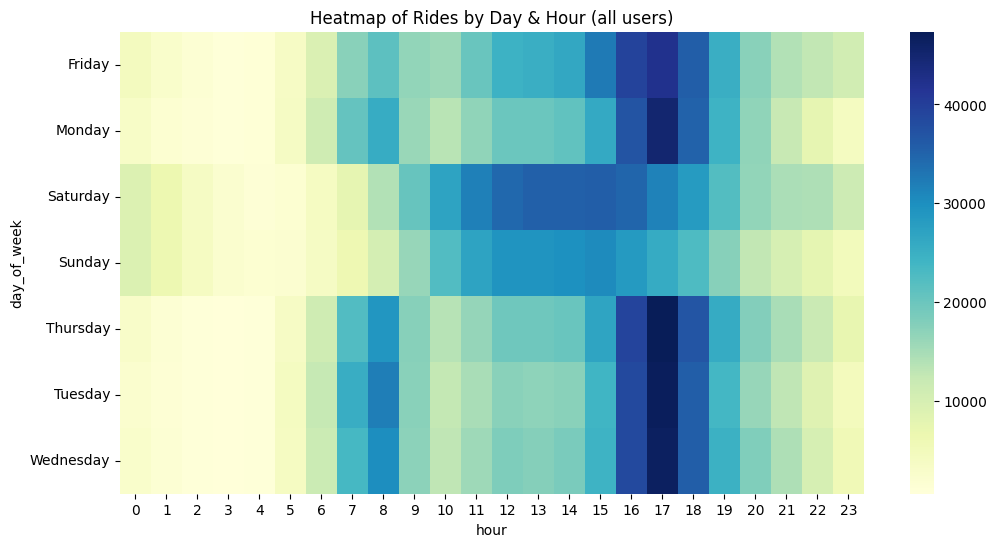

In [ ]:
# Add weekend/weekday column
combined_df['day_type'] = combined_df['day_of_week'].apply(lambda x: 'Weekend' if x in ['Saturday','Sunday'] else 'Weekday')

# Compare weekday vs weekend usage
weekday_usage = combined_df.groupby(['day_type','member_casual']).size().reset_index(name='count')
print(weekday_usage)

# Heatmap (hour × day)
heatmap_data = combined_df.groupby(['day_of_week','hour','member_casual']).size().reset_index(name='count')
pivot_heatmap = heatmap_data.pivot_table(index='day_of_week', columns='hour', values='count', fill_value=0)

plt.figure(figsize=(12,6))
sns.heatmap(pivot_heatmap, cmap="YlGnBu")
plt.title("Heatmap of Rides by Day & Hour (all users)")
plt.show()

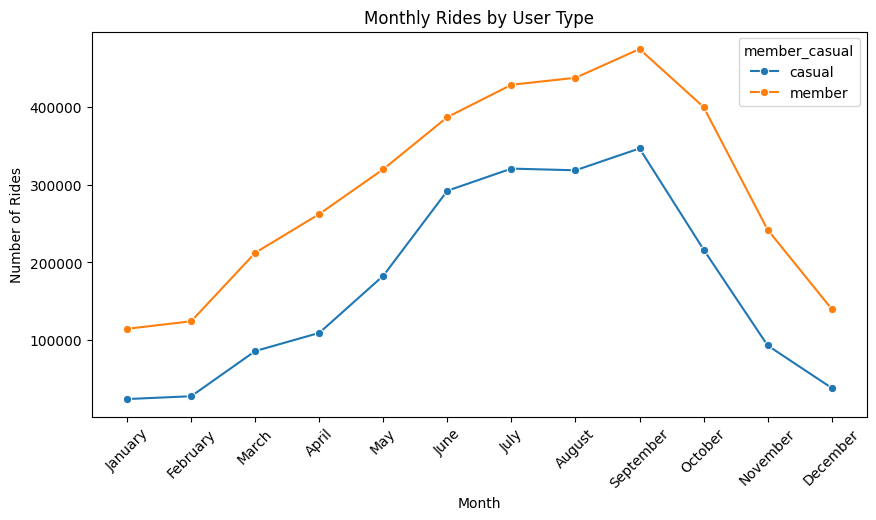

In [ ]:
# Monthly rides by membership type
# Convert numeric month to month name
combined_df['month_name'] = combined_df['month'].apply(lambda x: calendar.month_name[x])

# Group by month name instead
monthly_trends = combined_df.groupby(['month_name','member_casual']).size().reset_index(name='count')

# To keep months in calendar order
monthly_trends['month_name'] = pd.Categorical(monthly_trends['month_name'],
                                              categories=list(calendar.month_name[1:]),
                                              ordered=True)
plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_trends, x='month_name', y='count', hue='member_casual', marker='o')
plt.title("Monthly Rides by User Type")
plt.xlabel("Month")
plt.ylabel("Number of Rides")
plt.xticks(rotation=45)  # optional, rotates month names for readability
plt.show()

In [ ]:
if 'rideable_type' in combined_df.columns:
    bike_type_usage = combined_df.groupby(['member_casual','rideable_type']).size().reset_index(name='count')
    print(bike_type_usage)

  member_casual     rideable_type    count
0        casual      classic_bike   843169
1        casual     electric_bike  1126845
2        casual  electric_scooter    85215
3        member      classic_bike  1486356
4        member     electric_bike  1996280
5        member  electric_scooter    59122


In [ ]:
if 'bikeid' in combined_df.columns:
    trips_per_bike = combined_df.groupby('bikeid').size().reset_index(name='trip_count')
    print(trips_per_bike.describe())

In [ ]:
# First, rename the ride_length column to ride_length_min for clarity
combined_df['ride_length_min'] = combined_df['ride_length']  # already in minutes

# --- ADD THIS PART: create a season column ---
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

combined_df['season'] = combined_df['month'].apply(get_season)

**Expoert data for visulization in power bi**

In [ ]:
# Select the columns to export (now including 'season')
export_df = combined_df[[
    'ride_id',
    'rideable_type',
    'started_at',
    'ended_at',
    'ride_length_min',
    'day_of_week',
    'month',
    'season',        # <- add this
    'hour',
    'start_station_name',
    'end_station_name',
    'member_casual'
]]

# Create a folder in your Drive for processed data if it doesn't exist
import os
export_folder = "/content/drive/MyDrive/case study1/clean data"
os.makedirs(export_folder, exist_ok=True)

# Export to CSV
export_file = os.path.join(export_folder, "cyclistic_cleaned.csv")
export_df.to_csv(export_file, index=False)

print(f"✅ Cleaned data exported successfully to: {export_file}")

✅ Cleaned data exported successfully to: /content/drive/MyDrive/case study1/clean data/cyclistic_cleaned.csv
